# Sex and The City Script Text Analysis

The purpose of this project is the analysis of the entire script of the TV Show Sex and The City. Sex and the City is an American romantic comedy-drama television series created by Darren Star and produced by HBO. 

# Table of Content
0. [Downloads and Libraries](#lud)  

1. [Exploratory Data Analyis](#eda)  
2. [Text Preprocessing](#text-prepro)
   * [Tokenization](#tokenization)
3. [Natural Language Processing](#nlp)
    * [Lemmatization](#lemmatization)
    * [TF-IDF](#tfidf)
4. [Predictive Modeling](#prediction)
    * [Dimensionality Reduction](#dimensionality)   
        * [Preselection of Features](#pre-feat)   
        * [Principal Component Analysis](#pca) 
    * [Linear Regression](#linreg)
    * [Model Comparison](#modelcomp)
   

## Downloads and Libraries <a class="anchor" id="lud"></a>

In [3]:
import pandas as pd
import math
import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt

# NLP library imports
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import word_tokenize

from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize

#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('stopwords')

#Scikit Learn
from sklearn.feature_extraction.text import TfidfVectorizer


## Exploratory Data Analyis <a class="anchor" id="eda"></a>

The present data set consists of 39988 lines of text with an average reating of 7.52 on IMDB. The poorest rating is 7.0, the highest rating is 8.8. The data set contains 94 unique episodes.

In [4]:
satc_all_lines_w_rating = pd.read_csv("satc_all_lines_w_rating.csv").drop(["Unnamed: 0"],axis=1)
#create col with season and episode
satc_all_lines_w_rating['S_E'] = satc_all_lines_w_rating['Season'].astype(int).astype(str)+"_"+satc_all_lines_w_rating['Episode'].astype(int).astype(str)
satc_all_lines_w_rating.head()

,Season,Episode,Speaker,Line,date_job,ep_data_name,ep_data_url,ID,Rating,S_E
0,1,1,Carrie,"Once upon a time, an English journalist came t...",NaN,Sex and the City,https://www.imdb.com/title/tt0698663/?ref_=tte...,698663,7.4,1_1
1,1,1,Carrie,Elizabeth was attractive and bright.,NaN,Sex and the City,https://www.imdb.com/title/tt0698663/?ref_=tte...,698663,7.4,1_1
2,1,1,Carrie,Right away she hooked up with one of the city'...,NaN,Sex and the City,https://www.imdb.com/title/tt0698663/?ref_=tte...,698663,7.4,1_1
3,1,1,Tim,The question remains-- Is this really a compan...,NaN,Sex and the City,https://www.imdb.com/title/tt0698663/?ref_=tte...,698663,7.4,1_1
4,1,1,Carrie,"Tim was 42, a well-liked and respected investm...",NaN,Sex and the City,https://www.imdb.com/title/tt0698663/?ref_=tte...,698663,7.4,1_1


In [5]:
satc_all_lines_w_rating.describe()

,Season,Episode,ID,Rating
count,39988.000000,39988.000000,39988.000000,39988.000000
mean,3.687756,8.895294,698654.055267,7.524682
std,1.695484,5.324958,27.089066,0.282150
min,1.000000,1.000000,698608.000000,7.000000
25%,2.000000,4.000000,698631.000000,7.300000
50%,4.000000,8.000000,698653.000000,7.500000
75%,5.000000,13.000000,698677.000000,7.700000
max,6.000000,20.000000,698701.000000,8.800000


In [6]:
len(satc_all_lines_w_rating['S_E'].unique())

94

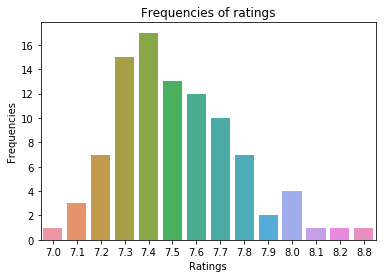

In [7]:
# Plotting rating distribution
X_ratings = satc_all_lines_w_rating.groupby(['S_E']).min().Rating.value_counts()
x = sns.barplot(X_ratings.index,X_ratings)
x.set(xlabel='Ratings',ylabel='Frequencies',title='Frequencies of ratings'.format(satc_all_lines_w_rating.shape[0]))
plt.show()
#X_ratings

## Text Preprocessing <a class="anchor" id="#text-prepro"></a>

In order to perform an analysis of the present text, we pre-process the text (represented by seperate lines in our data set). We bring all words to lowercase to be able to compare words across their position in a sentence ("Hello" and "hello" should be the same word). We furthermore strip all text of special characters. 

In [8]:
#text transformation
satc_all_lines_w_rating["cleaned"] = satc_all_lines_w_rating.Line.tolist()
#all to lowercase 
satc_all_lines_w_rating.cleaned = [str(line).lower() for line in satc_all_lines_w_rating.cleaned]

#remove special chars
chars_remove = ["@", "/", "#", ".", ",", "!", "?", "(", ")", "-", "_","’","'", "\"", ":"]
trans_dict = {initial:" " for initial in chars_remove}
satc_all_lines_w_rating.cleaned = [line.translate(str.maketrans(trans_dict)) for line in satc_all_lines_w_rating.cleaned]
satc_all_lines_w_rating.head()

print("Before transformation:",satc_all_lines_w_rating.Line[0],"\n After transformation:", satc_all_lines_w_rating.cleaned[0])
satc_all_lines_w_rating.head()

Before transformation: Once upon a time, an English journalist came to New York. 
 After transformation: once upon a time  an english journalist came to new york 


,Season,Episode,Speaker,Line,date_job,ep_data_name,ep_data_url,ID,Rating,S_E,cleaned
0,1,1,Carrie,"Once upon a time, an English journalist came t...",NaN,Sex and the City,https://www.imdb.com/title/tt0698663/?ref_=tte...,698663,7.4,1_1,once upon a time an english journalist came t...
1,1,1,Carrie,Elizabeth was attractive and bright.,NaN,Sex and the City,https://www.imdb.com/title/tt0698663/?ref_=tte...,698663,7.4,1_1,elizabeth was attractive and bright
2,1,1,Carrie,Right away she hooked up with one of the city'...,NaN,Sex and the City,https://www.imdb.com/title/tt0698663/?ref_=tte...,698663,7.4,1_1,right away she hooked up with one of the city ...
3,1,1,Tim,The question remains-- Is this really a compan...,NaN,Sex and the City,https://www.imdb.com/title/tt0698663/?ref_=tte...,698663,7.4,1_1,the question remains is this really a compan...
4,1,1,Carrie,"Tim was 42, a well-liked and respected investm...",NaN,Sex and the City,https://www.imdb.com/title/tt0698663/?ref_=tte...,698663,7.4,1_1,tim was 42 a well liked and respected investm...


### Tokenization <a class="anchor" id="tokenization"></a>
We then tokenize the text, this means, we break up the text into invidiual tokens. We are using the NLTK tokenize package and are splitting sentences up into single tokens using word_tokenize. The method invoked by word_tokenize is using the "Treebank tokenizer", a tokenizer that uses regular expressions to tokenize text.

After tokenization, we remove stopwords from the text, using the english stopwords from NLTK. Stopwords are language specific word that carry no meaning for the purpose of a text analyis.

In [9]:
print(str(len(stopwords.words("english")) ) +" stopwords are included in the stopwords corpus for the English language, containing words such as" + str(stopwords.words("english")[20:34]))

179 stopwords are included in the stopwords corpus for the English language, containing words such as['himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs']


In [10]:
#We are using NLKT tokenizer to split all text up into individual tokens
satc_all_lines_w_rating["tokenized"] = [word_tokenize(line) for line in satc_all_lines_w_rating.cleaned]

#Removing stopwords for topic extraction using nltk stopwords library
stopw = stopwords.words('english')
satc_all_lines_w_rating["w_o_stopwords"] = [[token for token in line if token not in stopw if len(token)>2] for line in satc_all_lines_w_rating.tokenized]
satc_all_lines_w_rating.head()

print("Before transformation:",satc_all_lines_w_rating.Line[0],"\n After transformation:", satc_all_lines_w_rating.w_o_stopwords[0])

Before transformation: Once upon a time, an English journalist came to New York. 
 After transformation: ['upon', 'time', 'english', 'journalist', 'came', 'new', 'york']


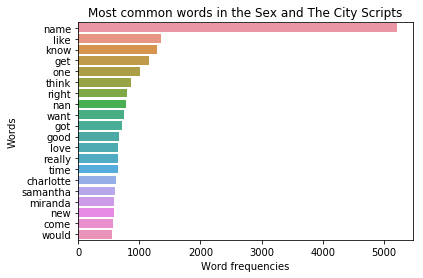

In [11]:
all_words = []
for line in satc_all_lines_w_rating["w_o_stopwords"]:
    for word in line:
        all_words.append(word)

dist = nltk.FreqDist(all_words)
X = [nb[1] for nb in dist.most_common(20)]
y = [nb[0] for nb in dist.most_common(20)]
x = sns.barplot(np.array(X),np.array(y))
x.set(xlabel='Word frequencies',ylabel='Words',title='Most common words in the Sex and The City Scripts')
plt.show()

Plotting the 20 most common names in the script shows us that "Name" and "nan" are among the top words, we take them out, as nan signifies not a number in our data base, and NAME is the result of an csv misformatting. 

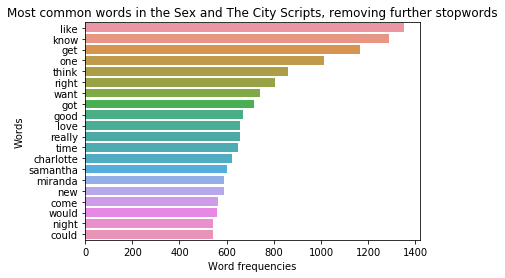

In [12]:
#addingnan and na to the list of stopwords
#main_chars = ["charlotte","samantha","carrie","miranda"]
new_stopw = stopw + ["nan","name"] #+ main_chars
satc_all_lines_w_rating["w_o_stopwords_2"] = [[token for token in line if token not in new_stopw if len(token)>2] for line in satc_all_lines_w_rating.tokenized]


all_words = []
for line in satc_all_lines_w_rating["w_o_stopwords_2"]:
    for word in line:
        all_words.append(word)

dist = nltk.FreqDist(all_words)
X = [nb[1] for nb in dist.most_common(20)]
y = [nb[0] for nb in dist.most_common(20)]
x = sns.barplot(np.array(X),np.array(y))
x.set(xlabel='Word frequencies',ylabel='Words',title='Most common words in the Sex and The City Scripts, removing further stopwords')
plt.show()

In [13]:
#saving tokenized data set
#satc_all_lines_w_rating.to_csv("satc_all_lines_w_rating_tokenized.csv")

## Natural Language Processing <a class="anchor" id="nlp"></a>
### Lemmatization <a class="anchor" id="lemmatization"></a>

In order to combine words that represent the same meaning, we are using the WordNetLemmatizer() to transform our corpus. "WordNet® is a large lexical database of English. Nouns, verbs, adjectives and adverbs are grouped into sets of cognitive synonyms (synsets), each expressing a distinct concept. Synsets are interlinked by means of conceptual-semantic and lexical relations." [Source: https://wordnet.princeton.edu]

In [14]:
# apply lemmatization from wordnet in order to merge words that come from the same meaning .- for example, "friend" and "friends" should be counted as the same word

def lemmatize(tokens):
    tokens = [WordNetLemmatizer().lemmatize(WordNetLemmatizer().lemmatize(WordNetLemmatizer().lemmatize(token,pos='a'),pos='v'),pos='n') for token in tokens]
    return tokens  

satc_all_lines_w_rating["lemmatized"] = [lemmatize(line) for line in satc_all_lines_w_rating.w_o_stopwords_2]

In [15]:
#look at the difference in words 
print(satc_all_lines_w_rating.w_o_stopwords_2[0:5])
print(satc_all_lines_w_rating.lemmatized[0:5])

0    [upon, time, english, journalist, came, new, y...
1                      [elizabeth, attractive, bright]
2    [right, away, hooked, one, city, typically, el...
3           [question, remains, really, company, want]
4    [tim, well, liked, respected, investment, bank...
Name: w_o_stopwords_2, dtype: object
0    [upon, time, english, journalist, come, new, y...
1                      [elizabeth, attractive, bright]
2    [right, away, hook, one, city, typically, elig...
3            [question, remain, really, company, want]
4    [tim, well, like, respect, investment, banker,...
Name: lemmatized, dtype: object


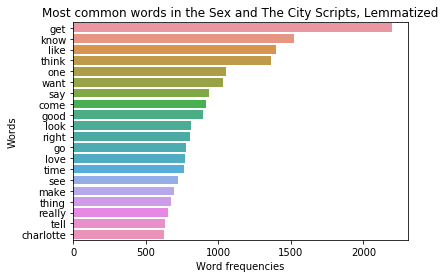

In [16]:
all_words = []
for line in satc_all_lines_w_rating["lemmatized"]:
    for word in line:
        all_words.append(word)

dist = nltk.FreqDist(all_words)
X = [nb[1] for nb in dist.most_common(20)]
y = [nb[0] for nb in dist.most_common(20)]
x = sns.barplot(np.array(X),np.array(y))
x.set(xlabel='Word frequencies',ylabel='Words',title='Most common words in the Sex and The City Scripts, Lemmatized')
plt.show()

### TF-IDF <a class="anchor" id="tfidf"></a>


Tf-Idf is a widely used statistic in the field of information retreival, used to quantify the relevance of a query or key word to a document inside a corpus.  It is commonly used in search engine optimization and text mining. The statistic is designed to assigns higher relevance to a term if it occurs often in the document, but penalize it if it occus in many different documents, i.e. it is not unique or specific to one or few documents. The general formula to compute the Tf-Idf score for term _t_ and documet _d_ in corpus _D_ is:

<center> 
$tf.idf(t,d,D)=tf(t,d)*idf(t,D)$ <br><br>
$=\frac{n(t,d)}{N(d)}*log\frac{|D|}{d(t)}$<br><br>
</center>
where:<br><br>
$tf(t,d)$ is the term frequency function<br><br>
$idf(t,D)$ is the inverse document frequency function<br><br>
$n(t,d)$ is the number of times t occurs in d<br><br>
$N(d)$ is the number of unique terms in d<br><br>
$d(t)$ is the number of documents in D which contain t<br><br>

We are using a TFIDF statistic across our data set in order to understand, which words are significant in describing the content per episode. In our dataset, a document are all the lines of text spoken in one episode, and the corpus are all episodes together. 

In [17]:
#group by episode to define one episode as one document for tf-idf

#initizalize new df
satc_text_per_episode = pd.DataFrame(
    columns=list(satc_all_lines_w_rating)[5:10])

#init
current_s_e = "1_1"
all_lines = []
#collect all speakers per episode 
all_speakers = []
carrie = 0
samantha = 0
miranda = 0
charlotte = 0

for index, row in satc_all_lines_w_rating.iterrows():
        if(row.S_E == current_s_e):
            #we use the lemmatized version of the lines, change here for different choice of text preprocessing
            all_lines.append(row.lemmatized)
            all_speakers.append(row.Speaker)
            
        if row.S_E != current_s_e:
            #flatten all tokens for previous episode and add them to the dataframe
            flat_all_lines = [word for line in all_lines for word in line]
            
            #count lines per main character 
            for name in all_speakers:
                if name == "Carrie":
                    carrie = carrie + 1
                if name == "Samantha":
                    samantha = samantha + 1
                if name == "Miranda":
                    miranda = miranda + 1
                if name == "Charlotte":
                    charlotte = charlotte + 1                
            
            
            #add a new row to new df, taking the information from the index-1 (the last s_e)
            satc_text_per_episode = satc_text_per_episode.append({'ep_data_name': satc_all_lines_w_rating.ep_data_name[index-1],
                                                                  'ep_data_url': satc_all_lines_w_rating.ep_data_url[index-1],
                                                                  'ID': satc_all_lines_w_rating.ID[index-1],
                                                                  'Rating': satc_all_lines_w_rating.Rating[index-1],
                                                                  'S_E': satc_all_lines_w_rating.S_E[index-1],
                                                                  'all_text': flat_all_lines,
                                                                  'all_speakers': all_speakers,
                                                                  'lines_carrie': carrie,
                                                                  'lines_samantha': samantha,
                                                                  'lines_charlotte':charlotte,
                                                                  'lines_miranda': miranda,
                                                                 
                                                                 }, ignore_index=True)
        
            #update vars
            all_lines = []
            all_speakers = []
            carrie = 0
            samantha = 0
            miranda = 0
            charlotte = 0
            current_s_e = row.S_E


satc_text_per_episode.head()

,ep_data_name,ep_data_url,ID,Rating,S_E,all_speakers,all_text,lines_carrie,lines_charlotte,lines_miranda,lines_samantha
0,Sex and the City,https://www.imdb.com/title/tt0698663/?ref_=tte...,698663,7.4,1_1,"[Carrie, Carrie, Carrie, Tim, Carrie, Carrie, ...","[upon, time, english, journalist, come, new, y...",150.0,33.0,29.0,26.0
1,Models and Mortals,https://www.imdb.com/title/tt0698649/?ref_=tte...,698649,7.4,1_2,"[Carrie, Nick, Nick , Miranda , Nick , Nick , ...","[date, nick, fairly, successful, sport, agent,...",108.0,6.0,9.0,25.0
2,Bay of Married Pigs,https://www.imdb.com/title/tt0698618/?ref_=tte...,698618,7.4,1_3,"[Carrie, Carrie, Carrie, Carrie, Carrie, Carri...","[friend, patience, husband, invite, hampton, w...",137.0,19.0,39.0,27.0
3,Valley of the Twenty-Something Guys,https://www.imdb.com/title/tt0698697/?ref_=tte...,698697,7.5,1_4,"[Carrie, Carrie, Carrie, Carrie, Carrie, Carri...","[seem, meet, everywhere, street, corner, party...",174.0,41.0,24.0,28.0
4,The Power of Female Sex,https://www.imdb.com/title/tt0698688/?ref_=tte...,698688,7.3,1_5,"[Carrie, Carrie, Samantha, Samantha, Carrie, S...","[host, balzac, overnight, become, restaurant, ...",138.0,18.0,30.0,37.0


In [18]:
##create the tfidf matrix
vect = TfidfVectorizer(analyzer ='word',ngram_range=(1,1),encoding='latin1')
vect_transformed = vect.fit_transform([text for text in satc_text_per_episode['all_text'].astype(str)])

feature_names = np.array(vect.get_feature_names())

satc_tfidf = pd.concat([satc_text_per_episode[['S_E','ep_data_name','ID','Rating']],
                        pd.DataFrame(vect_transformed.todense(), columns = feature_names)],axis=1)

#create a second dataframe containing the lines per character: 
satc_tfidf_LPC = pd.concat([satc_text_per_episode[['S_E','ep_data_name','ID','Rating','lines_carrie','lines_samantha','lines_charlotte','lines_miranda']],
                        pd.DataFrame(vect_transformed.todense(), columns = feature_names)],axis=1)

satc_tfidf.head()

,S_E,ep_data_name,ID,Rating,000,00am,00pm,100,1000,101,...,zoie,zone,zoo,zooey,zorro,zsa,zsu,zucchini,zygote,éclairs
0,1_1,Sex and the City,698663,7.4,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1_2,Models and Mortals,698649,7.4,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1_3,Bay of Married Pigs,698618,7.4,0.017015,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1_4,Valley of the Twenty-Something Guys,698697,7.5,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1_5,The Power of Female Sex,698688,7.3,0.069914,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
#some words with smallest and largest tfids
sorted_tfidf_index = vect_transformed.max(0).toarray()[0].argsort()
print('Smallest tfidf:\n{}\n'.format(feature_names[sorted_tfidf_index[:10]]))
print('Largest tfidf: \n{}'.format(feature_names[sorted_tfidf_index[:-11:-1]]))

Smallest tfidf:
['tiny' 'whenever' 'familiar' 'obvious' 'track' 'skin' 'perform' 'hall'
 'replace' 'tip']

Largest tfidf: 
['laney' 'threesome' 'pattern' 'fake' 'soul' 'model' 'yankee' 'phil'
 'javier' 'zsa']


## Predictive Modeling <a class="anchor" id="prediction"></a>

### Dimensionality Reduction  <a class="anchor" id="dimensionality"></a> 

Calculating the TF-IDF scores for each word that occurs in the data set, we end up with a matrix of the shape 93x8926, 93x8930 if we want to includge the lines spoken per character per episode in our data set. We are dealing with p>>n, a data set where the number of then the number of variables is much higher then the number of observations. We furthermore have an extremely sparse matrix because of the nature of the TF-IDF matrix. 

We are going to look at different ways to reduce the dimensionality: 
 + Preselection of features based on their TF-IDF scores
 + Dimensionality Reduction based on Principal Component Analysis


In [20]:
satc_tfidf.shape

(93, 8926)

In [21]:
satc_tfidf_LPC.shape

(93, 8930)

#### Preselection of Features  <a class="anchor" id="pre-feat"></a> 

In [22]:
from collections import Counter

def get_features(method ='tf', k=100):
    k=k
    if (method == 'tfidf'):
        #getting topK highest tfidf words
        top_k = feature_names[sorted_tfidf_index[:-(k+1):-1]]
    elif (method == 'tf'):
        #topK most common words
        counter = Counter([item for sublist in satc_text_per_episode['all_text'] for item in sublist])
        top_k = counter.most_common(k)
    else:
        top_k = None
        print("Bad input!! Choose tf or tfidf as first arg")
    
    return list(top_k)

In [23]:
features_words = get_features('tfidf',50)
features_words

['laney',
 'threesome',
 'pattern',
 'fake',
 'soul',
 'model',
 'yankee',
 'phil',
 'javier',
 'zsa',
 'church',
 'honeymoon',
 'shrink',
 'ghost',
 'sandwich',
 'whore',
 'rabbit',
 'sam',
 'cheat',
 'dildo',
 'karma',
 'jim',
 'fetish',
 'bitsy',
 'jeremy',
 'atlantic',
 'leslie',
 'review',
 'berger',
 'myth',
 'paris',
 'change',
 'train',
 'gay',
 'money',
 'mao',
 'weight',
 'vogue',
 'shoe',
 'pregnant',
 'stewardess',
 'ray',
 'raw',
 'marry',
 'freak',
 'ovary',
 'keith',
 'game',
 'hubbell',
 'taddy']

 #### Principal Component Analysis  <a class="anchor" id="pca"></a> 

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)

### Linear Regression <a class="anchor" id="linreg"></a>

#### Penalized Regression using Lasso

In [25]:
from sklearn import linear_model
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso

lasso_model = LassoCV(n_alphas=100, alphas=[.01,.1,1,10,100]) 

features_df = satc_tfidf[satc_tfidf.columns[4:]].filter(features_words,axis=1)
features = features_df.values

target_df = satc_tfidf['Rating']
target = target_df.values

In [26]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics 

#only keep 95% of vars 
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
pca


results={}
labels = satc_tfidf['Rating'].unique()
num_run = 10

#get ten results to account for randomness 
for i in range (num_run):
       
    # separate datasets into training and test datasets once, no folding
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3)
   
    # train the features and target datasets and fit to a model
    trained_lm = lasso_model.fit(features_train, target_train)


    # predict target with feature test set using trained model
    target_pred_train = list(trained_lm.predict(features_train))
    target_pred_test = list(trained_lm.predict(features_test))

    results[i]=[metrics.mean_squared_error(target_test, target_pred_test),
            metrics.mean_absolute_error (target_test, target_pred_test),
            metrics.explained_variance_score(target_test, target_pred_test),
            metrics.r2_score(target_test, target_pred_test),
               ]

res = pd.DataFrame.from_dict(data=results,orient='index',columns=['MSE','MAbsE', 'Explained_variance_score','R^2']) 
res.MAbsE.mean()



0.19758791208791207

In [27]:
#model_comparison_df

### Regression Trees


In [28]:
# Get the predictors and the response values
X = satc_tfidf[satc_tfidf.columns[4:]].filter(features_words,axis=1).values

y = satc_tfidf['Rating'].values
# The lab uses a 50/50 split. We'll do the same
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=0)

satc_tfidf.head()
len(X_train)
len(satc_tfidf[satc_tfidf.columns[4:]].filter(features_words,axis=1).values)

93

In [29]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import tree, export_graphviz
import graphviz


# Create an sklearn decision tree object using the mse metric for splitting, considering all the features and 
# splitting if there are more than 10 samples at a node.
tree = DecisionTreeRegressor(max_features=None, min_samples_split=10)
tree_est = tree.fit(X_train, y_train)
tree_est

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

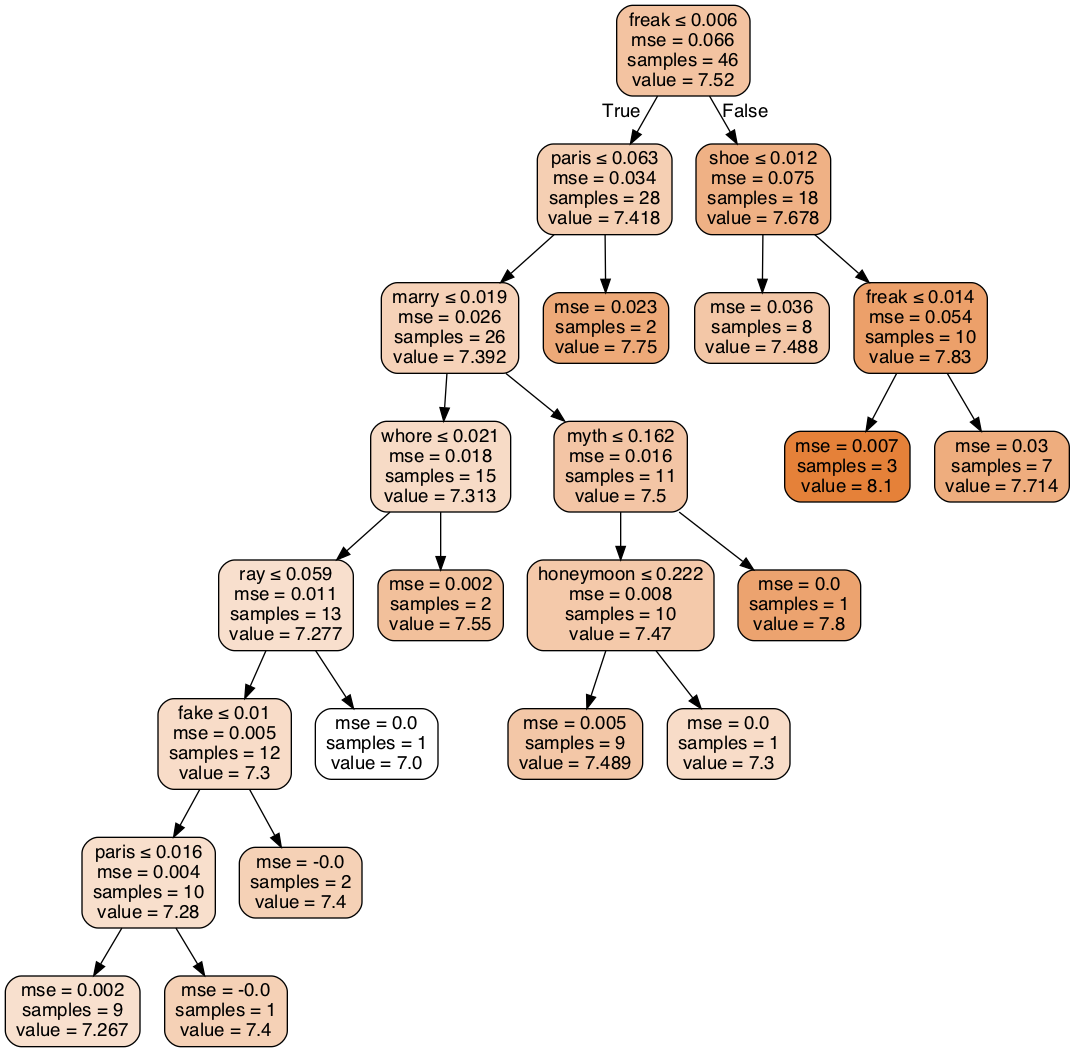

In [30]:
from IPython.display import Image, display


# use sklearn's export to generate the dot-data string file with all the nodes and their props.
dot_data = export_graphviz(tree_est, out_file='boston_tree.dot',feature_names=satc_tfidf[satc_tfidf.columns[4:]].filter(features_words,axis=1).columns[0:],filled=True, 
                           rounded=True, special_characters=True)

with open('boston_tree.dot') as f:
    dot_graph = f.read()  

# create the source object
I = graphviz.Source(dot_graph, format='png', engine='dot')
# Use ipython Image to shrink the rendered image of the source obj to fit into jupyter nb.
Image(I.render())


In [31]:
feature_importances = pd.Series(data=tree.feature_importances_, index=list(satc_tfidf[satc_tfidf.columns[4:]].filter(features_words,axis=1)))
feature_importances.sort_values(axis=0, ascending=False)

freak         0.435662
shoe          0.215779
paris         0.104963
marry         0.091520
whore         0.053496
myth          0.040974
ray           0.034384
honeymoon     0.013290
fake          0.009933
shrink        0.000000
rabbit        0.000000
sam           0.000000
sandwich      0.000000
cheat         0.000000
dildo         0.000000
ghost         0.000000
taddy         0.000000
zsa           0.000000
church        0.000000
jim           0.000000
javier        0.000000
phil          0.000000
yankee        0.000000
model         0.000000
soul          0.000000
pattern       0.000000
threesome     0.000000
karma         0.000000
jeremy        0.000000
fetish        0.000000
mao           0.000000
game          0.000000
keith         0.000000
ovary         0.000000
raw           0.000000
stewardess    0.000000
pregnant      0.000000
vogue         0.000000
weight        0.000000
money         0.000000
bitsy         0.000000
gay           0.000000
train         0.000000
change     

Test MSE =  0.06873614428040715


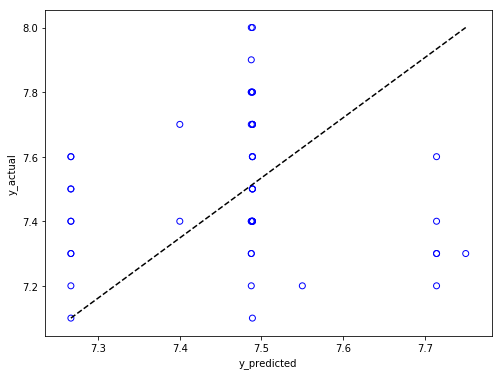

In [32]:
# Get the predictions from the tree for the test set
y_pred = tree_est.predict(X_test)

# Scatter plot the predicted versus actual values
fig,ax = plt.subplots(1,1, figsize=(8,6));
ax.scatter(y_pred, y_test, facecolor='None', edgecolor='b');
# add a reference unity line
ax.plot([min(y_pred), max(y_pred)], [min(y_test), max(y_test)], linestyle='--', color='k');
ax.set_xlabel('y_predicted')
ax.set_ylabel('y_actual')

# print the mse
mse_dt = np.mean((y_pred-y_test)**2)
print("Test MSE = ", mse_dt)

In [33]:
features_words = get_features('tfidf',150)

In [34]:
error_rates_regression_tree=[metrics.mean_squared_error(y_test, y_pred),
            metrics.mean_absolute_error (y_test, y_pred),
            metrics.explained_variance_score(y_test, y_pred),
            metrics.r2_score(y_test, y_pred)]

In [35]:
error_rates_regression_tree

[0.06873614428040715,
 0.21830462681526505,
 -0.3376296884001828,
 -0.35739444587358715]

## Bagging Model

In [36]:
from sklearn.ensemble import RandomForestRegressor

bagger = RandomForestRegressor(n_estimators=500)
bag_est =  bagger.fit(X_train, y_train)


Test MSE =  0.05459010382978512


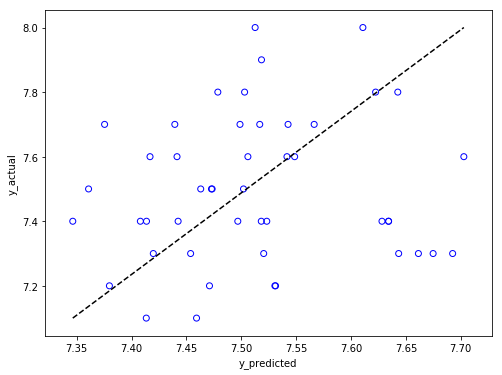

In [37]:
y_pred = bagger.predict(X_test)

# Plot the predicted vs the actual medv response
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.scatter(y_pred, y_test, facecolor='None', edgecolor='b')
# add a reference unity line
ax.plot([min(y_pred), max(y_pred)], [min(y_test), max(y_test)], linestyle='--', color='k');
ax.set_xlabel('y_predicted')
ax.set_ylabel('y_actual')

mse_ba = np.mean((y_pred-y_test)**2)
print("Test MSE = ", mse_ba)

In [38]:
error_rates_bagging=[metrics.mean_squared_error(y_test, y_pred),
            metrics.mean_absolute_error (y_test, y_pred),
            metrics.explained_variance_score(y_test, y_pred),
            metrics.r2_score(y_test, y_pred)]

In [39]:
error_rates_bagging

[0.05459010382978512,
 0.196944680851061,
 -0.07422086894327906,
 -0.07803986554617692]

# Random Forest

## XG Boost

In [40]:
import xgboost as xgb
features_df 
#target_df
test_df = pd.concat([target_df,features_df],axis=1)[0:60]
train_df = pd.concat([target_df,features_df],axis=1)[60:]
#train_df = pd.concat([target_df,features_df],axis=1)

In [41]:
model = xgb.XGBRegressor( max_depth=4)

In [42]:
model.fit(features_train,target_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [43]:
y_pred = model.predict(features_test)

Test MSE =  0.07318375728620956


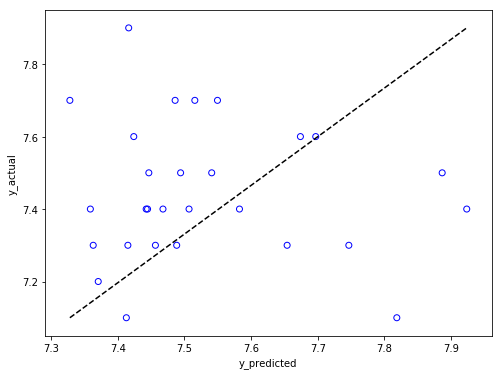

In [44]:
y_test=target_test
# Plot the predicted vs the actual medv response
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.scatter(y_pred, y_test, facecolor='None', edgecolor='b')
# add a reference unity line
ax.plot([min(y_pred), max(y_pred)], [min(y_test), max(y_test)], linestyle='--', color='k');
ax.set_xlabel('y_predicted')
ax.set_ylabel('y_actual')

mse_ba = np.mean((y_pred-y_test)**2)
print("Test MSE = ", mse_ba)

In [45]:
#pd.DataFrame(y_test,y_pred)

In [46]:
error_rates_xgboost=[metrics.mean_squared_error(y_test, y_pred),
            metrics.mean_absolute_error (y_test, y_pred),
            metrics.explained_variance_score(y_test, y_pred),
            metrics.r2_score(y_test, y_pred)]

In [47]:
error_rates_xgboost


[0.07318375728620956,
 0.20619722434452606,
 -0.8605251047939357,
 -1.0705906067263893]

### Prediction Including the Lines per Character

We added four additional columns to the dataframe in order to take into account the lines spoken per character per episode. Plotting the lines spoken per person against their Ratings 

In [48]:
satc_tfidf_LPC.head()
corr_carrie = satc_tfidf_LPC['Rating'].corr(satc_tfidf_LPC['lines_carrie'])
corr_miranda = satc_tfidf_LPC['Rating'].corr(satc_tfidf_LPC['lines_miranda'])
corr_charlotte = satc_tfidf_LPC['Rating'].corr(satc_tfidf_LPC['lines_charlotte'])
corr_samantha = satc_tfidf_LPC['Rating'].corr(satc_tfidf_LPC['lines_samantha'])

print("Correlation between the ratings and lines spoken by Samantha {corr_samantha}\n".format(corr_samantha=corr_samantha))
print("Correlation between the ratings and lines spoken by Miranda {corr_miranda}\n".format(corr_miranda=corr_miranda))
print("Correlation between the ratings and lines spoken by Charlotte {corr_charlotte}\n".format(corr_charlotte=corr_charlotte))
print("Correlation between the ratings and lines spoken by Carrie {corr_carrie}\n".format(corr_carrie=corr_carrie))


Correlation between the ratings and lines spoken by Samantha 0.004264035929862553

Correlation between the ratings and lines spoken by Miranda 0.06440768413252036

Correlation between the ratings and lines spoken by Charlotte 0.004248455475821382

Correlation between the ratings and lines spoken by Carrie 0.15032605229827478



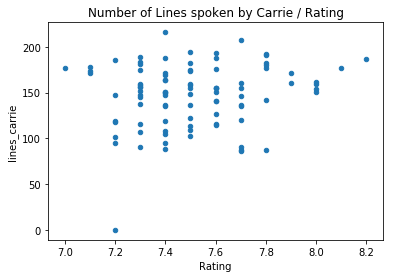

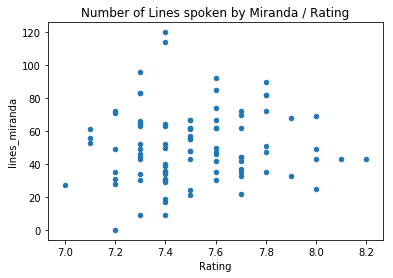

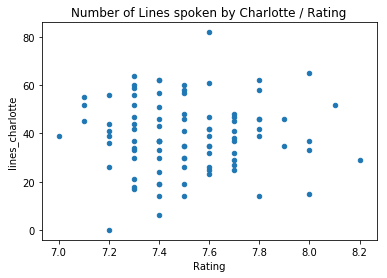

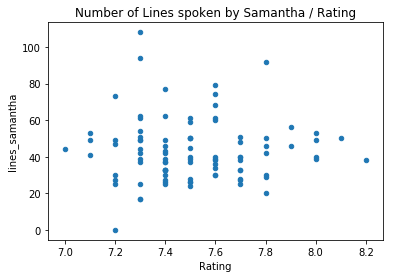

In [49]:
satc_tfidf_LPC.plot(x="Rating",y="lines_carrie",kind="scatter",title="Number of Lines spoken by Carrie / Rating")
satc_tfidf_LPC.plot(x="Rating",y="lines_miranda",kind="scatter",title="Number of Lines spoken by Miranda / Rating")
satc_tfidf_LPC.plot(x="Rating",y="lines_charlotte",kind="scatter",title="Number of Lines spoken by Charlotte / Rating")
satc_tfidf_LPC.plot(x="Rating",y="lines_samantha",kind="scatter",title="Number of Lines spoken by Samantha / Rating")

### Model Comparison <a class="anchor" id="modelcomp"></a>

In [50]:
#evaluate_model needs as arguments the number of features, pca dimensions (set None if no PCA), and the model you would like to evaluare 
#as well as the dataframe with tfdif scores 

#LPC is a boolean indicating whether we take lines per character into account (different slicing of df)

def evaluate_model(modelname,model,number_of_features,pca_dim,df,LPC=False):
    
    #get the words that we will look at in the analysis
    selected_words = get_features('tfidf',number_of_features)
    
    #define the features and targets 
    if LPC == False:
        features = df[df.columns[4:]].filter(selected_words,axis=1).values
        target= df['Rating'].values
    
    #if we also use lines per character, we need to select different cols
    if LPC == True:
        features = df[df.columns[8:]].filter(selected_words,axis=1).values
        target= df['Rating'].values
    

    #if pca_dim != None, create the pca model 
    if pca_dim: 
        pca = PCA(n_components=pca_dim)

    
    results={}
    #labels = satc_tfidf['Rating'].unique()
    num_run = 20

    #get ten results to account for randomness 
    for i in range (num_run):

        # separate datasets into training and test datasets once, no folding
        features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3)
        
        #if pca, apply the dim reduction 
        if pca_dim: 
                features_train = pca.fit_transform(features_train)
                features_test = pca.transform(features_test)

        # train the features and target datasets and fit to a model
        trained_model = model.fit(features_train, target_train)


        # predict target with feature test set using trained model
        target_pred_train = list(trained_model.predict(features_train))
        target_pred_test = list(trained_model.predict(features_test))

        results[i]=[metrics.mean_squared_error(target_test, target_pred_test),
                metrics.mean_absolute_error (target_test, target_pred_test),
                metrics.explained_variance_score(target_test, target_pred_test),
                metrics.r2_score(target_test, target_pred_test),
                   ]

    results = pd.DataFrame.from_dict(data=results,orient='index',columns=['MSE','MAbsE', 'Explained_variance_score','R_squared']) 
    model_details_and_averages = [
    str(modelname),
    number_of_features,pca_dim,
    results.MSE.mean(),
    results.MAbsE.mean(),
    results.Explained_variance_score.mean(),
    results.R_squared.mean(),
    ]

    
    return results,model_details_and_averages 
evaluate_model("Lasso",lasso_model,50,50,satc_tfidf)[1]
evaluate_model("Lasso",lasso_model,50,50,satc_tfidf_LPC,True)[1]


['Lasso',
 50,
 50,
 0.05770352916314451,
 0.1951730769230768,
 1.6653345369377347e-17,
 -0.0726556217566265]

In [58]:
import xgboost as xgb

model_comparison_df = pd.DataFrame(columns=["Name","features","pca_dim",'MSE','MAbsE', 'Explained_variance_score','R_squared'])
#evaluate_model(model, number_of_features,pca_dim,df):

#get model scores, average of ten iterations 
lasso = evaluate_model("lasso",lasso_model,50,50,satc_tfidf)[1]



#add to model comparison df 
model_comparison_df.loc[len(model_comparison_df)] = lasso

#add new models to compare like this
model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("lasso",lasso_model,100,50,satc_tfidf)[1]

model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("lasso",lasso_model,100,10,satc_tfidf)[1]
model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("lasso_LinesPerCharacter",lasso_model,50,50,satc_tfidf_LPC,True)[1]

#Decision Tree Regressor
tree = DecisionTreeRegressor(max_features=None, min_samples_split=10)
model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("Tree",tree,50,50,satc_tfidf)[1]
model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("Tree",tree,100,50,satc_tfidf)[1]
model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("Tree",tree,150,50,satc_tfidf)[1]
model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("Tree",tree,25,None,satc_tfidf)[1]
model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("Tree",tree,35,None,satc_tfidf)[1]


model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("Tree_LPC",tree,50,None,satc_tfidf_LPC,True)[1]

model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("Tree",tree,50,None,satc_tfidf)[1]
model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("Tree",tree,100,None,satc_tfidf)[1]
model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("Tree",tree,150,None,satc_tfidf)[1]

#bagging
bagger = RandomForestRegressor(n_estimators=500)
model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("Bagging_LPC",bagger,50,None,satc_tfidf_LPC,True)[1]

model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("Bagging",bagger,50,None,satc_tfidf)[1]
model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("Bagging",bagger,100,None,satc_tfidf)[1]
model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("Bagging",bagger,150,None,satc_tfidf)[1]
model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("Bagging",bagger,50,50,satc_tfidf)[1]
model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("Bagging",bagger,100,25,satc_tfidf)[1]
model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("Bagging",bagger,150,2,satc_tfidf)[1]


In [ ]:

#XGB
xgb_2 = xgb.XGBRegressor(max_depth=2)
model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("xgb_2",xgb_2,50,None,satc_tfidf)[1]
model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("xgb_2",xgb_2,2000,20,satc_tfidf)[1]

xgb = xgb.XGBRegressor(max_depth=4)
model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("xgb",xgb,50,None,satc_tfidf)[1]
model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("xgb",xgb,100,None,satc_tfidf)[1]
xgb_10 = xgb.XGBRegressor(max_depth=10)
model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("xgb_10",xgb_10,150,None,satc_tfidf)[1]
model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("xgb",xgb,50,50,satc_tfidf)[1]
model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("xgb",xgb,50,2,satc_tfidf)[1]

In [59]:
model_comparison_df

,Name,features,pca_dim,MSE,MAbsE,Explained_variance_score,R_squared
0,lasso,50,50,0.059108,0.195959,-2.220446e-17,-0.089205
1,lasso,100,50,0.058919,0.195541,4.440892e-17,-0.065986
2,lasso,100,10,0.059989,0.198992,-2.220446e-17,-0.065180
3,lasso_LinesPerCharacter,50,50,0.062832,0.205330,-2.220446e-17,-0.095893
4,Tree,50,50,0.131716,0.290428,-1.229515e+00,-1.490609
5,Tree,100,50,0.123386,0.289199,-9.612770e-01,-1.187099
6,Tree,150,50,0.104439,0.262768,-7.050168e-01,-0.936339
7,Tree,25,None,0.088217,0.239861,-6.271693e-01,-0.678915
8,Tree,35,None,0.104847,0.260039,-7.012528e-01,-0.779397
9,Tree_LPC,50,None,0.098410,0.249145,-7.155667e-01,-0.783798
